In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! unzip /content/drive/My\ Drive/glove.6B.zip

In [0]:
import pandas as pd
import io
import requests

url="https://raw.githubusercontent.com/WillKoehrsen/recurrent-neural-networks/master/data/neural_network_patent_query.csv"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [2]:
original_abstracts = list(data['patent_abstract'])
len(original_abstracts)

data.head()

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [3]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
import re

def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    return patent


In [5]:
formatted = []

# Iterate through all the original abstracts
for a in original_abstracts:
    formatted.append(format_patent(a))

len(formatted)

3522

In [0]:
RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 1
SAVE_MODEL = True






def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

In [0]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    
    
    return X_train, X_valid, y_train, y_valid







In [11]:
import numpy as np

X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape
y_train.shape

(224616, 13677)

In [24]:
from keras.utils import get_file

# Vectors to use
glove_vectors = 'glove.6B.zip'

# Download word embeddings if they are not present
glove_vectors = 'glove.6B.100d.txt'

glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

In [137]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 2941 words without pre-trained embeddings.


In [28]:
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [0]:

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

In [0]:

from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks




In [0]:
RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 1
SAVE_MODEL = True

##GRU Model

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,GRU
from keras import regularizers
model = Sequential()

# Embedding layer
model.add(
    Embedding(input_dim=num_words,
              input_length = TRAINING_LEGNTH,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
#model.add(LSTM(64, return_sequences=False, 
               #dropout=0.1, recurrent_dropout=0.1))

model.add(GRU(64, activation='tanh', recurrent_activation='softmax', use_bias=True, kernel_initializer='Orthogonal', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.1, recurrent_dropout=0.1, implementation=2, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, reset_after=False))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

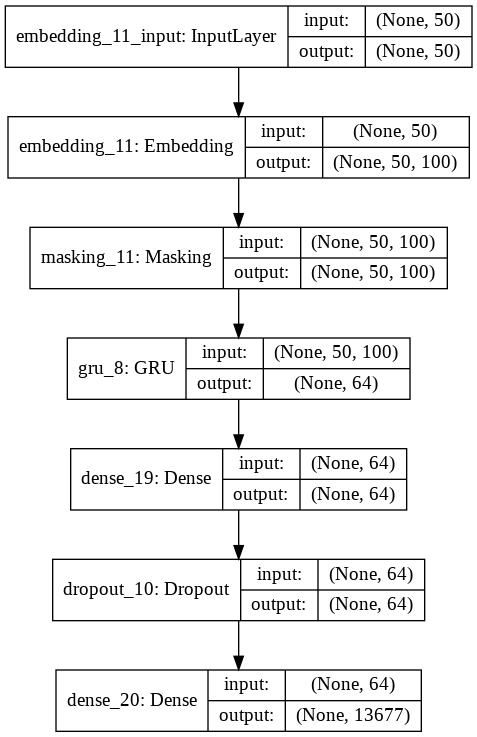

In [98]:
from IPython.display import Image
model_name = 'pre-trained-gru'
model_dir = '../models/'

plot_model(model, to_file=f'{model_name}.png', show_shapes=True)

In [99]:
history=model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))


Train on 224616 samples, validate on 96265 samples
Epoch 1/100
224616/224616 [==============================] - 30s 134us/step - loss: 7.9528 - acc: 0.0620 - val_loss: 6.4238 - val_acc: 0.0872
Epoch 2/100
224616/224616 [==============================] - 27s 121us/step - loss: 6.3257 - acc: 0.0863 - val_loss: 6.2227 - val_acc: 0.0872
Epoch 3/100
224616/224616 [==============================] - 27s 120us/step - loss: 6.2114 - acc: 0.0864 - val_loss: 6.1729 - val_acc: 0.0872
Epoch 4/100
224616/224616 [==============================] - 27s 120us/step - loss: 6.1496 - acc: 0.0945 - val_loss: 6.0994 - val_acc: 0.1112
Epoch 5/100
224616/224616 [==============================] - 27s 120us/step - loss: 6.0945 - acc: 0.1087 - val_loss: 6.0596 - val_acc: 0.1196
Epoch 6/100
224616/224616 [==============================] - 27s 120us/step - loss: 6.0609 - acc: 0.1139 - val_loss: 6.0346 - val_acc: 0.1233
Epoch 7/100
224616/224616 [==============================] - 27s 120us/step - loss: 6.0359 - acc:

In [0]:
callbacks = make_callbacks(model_name)

In [0]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'{model_name}.h5')
    r = model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model

In [104]:

model_gru = load_and_evaluate(model_name, return_model=True)

96265/96265 [==============================] - 8s 83us/step
Cross Entropy: 5.3928
Accuracy: 18.16%


**LSTM** **MODEL**

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,GRU
from keras import regularizers
model = Sequential()

# Embedding layer
model.add(
    Embedding(input_dim=num_words,
              input_length = TRAINING_LEGNTH,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False))

#model.add(GRU(64, activation='tanh', recurrent_activation='softmax', use_bias=True, kernel_initializer='Orthogonal', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.1, recurrent_dropout=0.1, implementation=2, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, reset_after=False))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
model_name = 'pre-trained-lstm'
callbacks = make_callbacks(model_name)


history_lstm=model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

Train on 224616 samples, validate on 96265 samples
Epoch 1/100
224616/224616 [==============================] - 26s 118us/step - loss: 4.6917 - acc: 0.1938 - val_loss: 4.9747 - val_acc: 0.2078
Epoch 2/100
224616/224616 [==============================] - 26s 118us/step - loss: 4.6817 - acc: 0.1942 - val_loss: 4.9833 - val_acc: 0.2095
Epoch 3/100
224616/224616 [==============================] - 26s 117us/step - loss: 4.6792 - acc: 0.1948 - val_loss: 4.9795 - val_acc: 0.2093
Epoch 4/100
224616/224616 [==============================] - 26s 117us/step - loss: 4.6745 - acc: 0.1954 - val_loss: 4.9766 - val_acc: 0.2078
Epoch 5/100
224616/224616 [==============================] - 26s 116us/step - loss: 4.6695 - acc: 0.1946 - val_loss: 4.9708 - val_acc: 0.2088
Epoch 6/100
224616/224616 [==============================] - 26s 117us/step - loss: 4.6640 - acc: 0.1954 - val_loss: 4.9705 - val_acc: 0.2086
Epoch 7/100
224616/224616 [==============================] - 26s 117us/step - loss: 4.6593 - acc:

In [0]:
model_name = 'pre-trained-lstm'
callbacks = make_callbacks(model_name)


In [125]:
model_lstm = load_and_evaluate(model_name, return_model=True)

96265/96265 [==============================] - 8s 85us/step
Cross Entropy: 4.9339
Accuracy: 21.42%


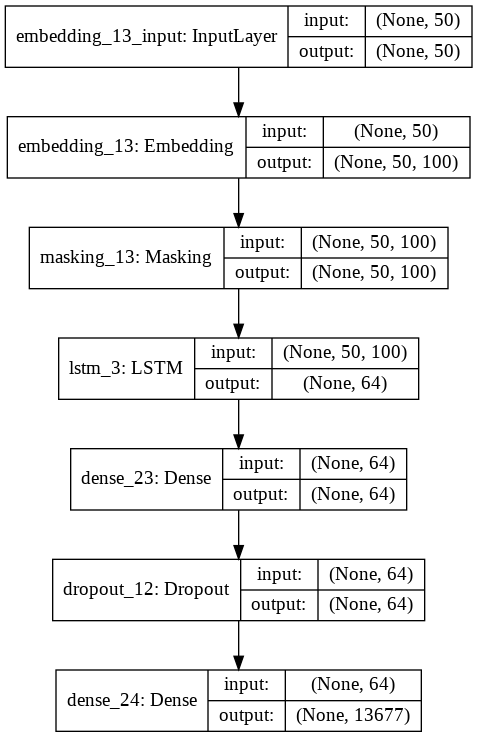

In [116]:
from IPython.display import Image
model_name = 'pre-trained-lstm'
model_dir = '../models/'

plot_model(model, to_file=f'{model_name}.png', show_shapes=True)

In [0]:
from IPython.display import HTML


def header(text, color='black'):
    raw_html = f'<h1 style="color: {color};"><center>' + \
        str(text) + '</center></h1>'
    return raw_html


def box(text):
    raw_html = '<div style="border:1px inset black;padding:1em;font-size: 20px;">' + \
        str(text)+'</div>'
    return raw_html


def addContent(old_html, raw_html):
    old_html += raw_html
    return old_html

In [0]:
import random


def generate_output(model,
                    sequences,
                    training_length=50,
                    new_words=50,
                    diversity=1,
                    return_output=False,
                    n_gen=1):
    """Generate `new_words` words of output from a trained model and format into HTML."""

    # Choose a random sequence
    seq = random.choice(sequences)

    # Choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)
    # Ending index for seed
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        # Find the actual entire sequence
        actual = generated[:] + seq[end_idx:end_idx + new_words]

        # Keep adding new words
        for i in range(new_words):

            # Make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(
                np.float64)

            # Diversify
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual abstract
        n = []

        for i in generated:
            n.append(idx_word.get(i, '< --- >'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))

    a = a[training_length:]

    gen_list = [
        gen[training_length:training_length + len(a)] for gen in gen_list
    ]

    if return_output:
        return original_sequence, gen_list, a

    # HTML formatting
    seed_html = ''
    seed_html = addContent(seed_html, header(
        'Seed Sequence', color='darkblue'))
    seed_html = addContent(seed_html,
                           box(remove_spaces(' '.join(original_sequence))))

    gen_html = ''
    gen_html = addContent(gen_html, header('LSTM Generated', color='darkred'))
    gen_html = addContent(gen_html, box(remove_spaces(' '.join(gen_list[0]))))

    a_html = ''
    a_html = addContent(a_html, header('Actual', color='darkgreen'))
    a_html = addContent(a_html, box(remove_spaces(' '.join(a))))

    return seed_html, gen_html, a_html

In [112]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent

seed_html, gen_html, a_html = generate_output(model, sequences,
                                              TRAINING_LENGTH)
HTML(seed_html)


In [113]:
HTML(gen_html)


In [114]:
HTML(a_html)

In [0]:
####LSTM

In [134]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent

seed_html, gen_html, a_html = generate_output(model, sequences,
                                              TRAINING_LENGTH)
HTML(seed_html)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


In [135]:
HTML(gen_html)

In [136]:
HTML(a_html)